In [1]:
import pickle, importlib, re, h5py, os, itertools, json, logging
from collections import Counter
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np, pandas as pd
from sklearn.preprocessing import minmax_scale, StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor, KernelDensity
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score
from scipy.stats import spearmanr, pearsonr, ttest_ind, fisher_exact, ttest_1samp, mannwhitneyu
from scipy.spatial import ConvexHull
from scipy.sparse import csr_matrix, coo_matrix, save_npz
from statsmodels.stats.multitest import multipletests
from matplotlib_venn import venn2
from anndata import AnnData
import scanpy as sc
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
path2figdir = Path('/work/magroup/tianming/Researches/sc-hic/data2/final/figures-mBC-paper')

In [3]:
filename = '/work/magroup/tianming/Researches/sc-hic/data/genome/mm10/gencode.vM25.annotation.gtf.gz'
df = pd.read_csv(
    filename,
    header=0,
    skiprows=5,
    usecols=[0, 2, 3, 4, 6, 8],
    index_col=False,
    names=['chrom', 'type', 'start', 'end', 'strand', 'annotation'],
    delimiter='\t',
)
df = df[df['type'].isin(['gene'])]
pattern = re.compile(r'gene_name "([^"]+)";')
df['gene_name'] = [pattern.search(_).group(1) for _ in df['annotation']]
pattern = re.compile(r'gene_type "([^;]+)";')
df['gene_type'] = [pattern.search(_).group(1) for _ in df['annotation']]
pattern = re.compile(r'gene_id "([^"]+)";')
df['ID'] = [pattern.search(_).group(1).split('.')[0] for _ in df['annotation']]
df['gene_id'] = df['ID']
df_gene_anno = df.set_index('gene_name')
df_gene_anno = df_gene_anno[~df_gene_anno.index.duplicated(keep=False)]
del df

# 1. Load GAGE-seq

## 1.1 Load GAGE-seq gene expression and meta data

In [4]:
lib_name, species = 'mBC', 'mm10'
walk_policy = 'complete'
res_str = '500kb'

path2root = Path('/work/magroup/tianming/Researches/sc-hic/data2/final')

adata = sc.read_10x_mtx(
    path2root / 'results' / f'RNA_{lib_name}_{walk_policy}_{species}_filtered_10x',
#     var_names='gene_ids',
)
cell_id_all = np.loadtxt(path2root / 'results' / f'RNA_{lib_name}_{walk_policy}_{species}_filtered_10x' / 'barcodes.tsv', dtype=object)
adata.obs.index = cell_id_all
with open(path2root / 'results' / f'meta_{lib_name}_{walk_policy}_{species}_filtered.pkl', 'rb') as f:
    df_meta = pickle.load(f)
adata.obs = pd.concat([adata.obs, df_meta], axis=1)
del df_meta

df_seurat = pd.read_csv(path2root / 'results' / 'meta-Seurat_mBC_complete_mm10_filtered.csv', index_col=0)
adata = adata[df_seurat.index].copy()
adata.obs['cell type'] = pd.Categorical(df_seurat['Idents.obj.'], categories=[
    "L2 IT RvPP", "L2/3 IT RSP", "L2/3 IT CTX a", "L2/3 IT CTX b", "L2/3 IT CTX c",
    "L4 IT CTX", "L4/5 IT CTX", "L5 IT RSP", "L5 IT CTX", "L6 IT CTX",
    "L5 PT CTX", "L6 CT CTX a", "L6 CT CTX b", "L5/6 NP CTX", "L6b CTX",
    "Pvalb a", "Pvalb b", "Sst a", "Sst b", "Vip", "Sncg", "Lamp5", "Meis2",
    "Astro", "OPC", "ODC", "VLMC", "Micro",
    "Unk",
])

adata_rna_raw = adata.copy()

sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy()
sc.pp.highly_variable_genes(adata)
sc.pp.scale(adata, max_value=10)

genes = adata.var.index.values
genes = genes[np.isin(genes, df_gene_anno.index.values)]
adata = adata[:, genes].copy()

adata_rna = adata
del adata

We group cells into 3 major cell types.

In [5]:
gage_exc_types = [
    "L2 IT RvPP", "L2/3 IT RSP", "L2/3 IT CTX a", "L2/3 IT CTX b", "L2/3 IT CTX c",
    "L4 IT CTX", "L4/5 IT CTX", "L5 IT RSP", "L5 IT CTX", "L6 IT CTX",
    "L5 PT CTX", "L6 CT CTX a", "L6 CT CTX b", "L5/6 NP CTX", "L6b CTX"]
gage_inh_types = [
    "Pvalb a", "Pvalb b", "Sst a", "Sst b", "Vip", "Sncg", "Lamp5", "Meis2"]
gage_glia_types = ["Astro", "OPC", "ODC", "VLMC", "Micro"]

## 1.2 Load GAGE-seq 3d genome structures

Here, we load single-cell insulation scores and single-cell A/B values.

In [6]:
path2root = Path(f'/work/magroup/tianming/Researches/sc-hic/data2/final/results/mBC_complete_mm10_filtered')
score_dict_raw = {}
for score_name, res_str, res in tqdm([
    ('is-hw5', '100kb', 1e5),
    ('is-hw10', '100kb', 1e5),
    ('ab', '100kb', 1e5),
]):
    with open(path2root / f'score-{res_str}-{score_name}.pkl', 'rb') as f:
        score_dict = pickle.load(f)
    score_dict = {key.split('_')[1]: value for key, value in score_dict.items()}
    mask = np.isin(cell_id_all, adata_rna.obs.index)
    assert np.all(cell_id_all[mask] == adata_rna.obs.index)
    score_dict = {key: value[mask] for key, value in score_dict.items()}
    score_dict_raw[score_name, res_str] = score_dict
    del score_name, res_str, res, score_dict

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
score_dict_all = score_dict_raw

# 2. Load Paired-Tag

## 2.1 Load Paired-Tag single-cell gene expression and meta data

In [8]:
path2dir = Path('/work/magroup/tianming/Researches/sc-hic/data/ref_datasets/Paired-Tag')
adata = sc.read_10x_mtx(path2dir / '01.Paired-Tag_seq_RNA_filtered_matrix')
df_meta = pd.read_csv(path2dir / 'Paired-seq-Table 1.csv', header=0, index_col=0)
df_meta['Target'] = 'RNA'
file_list = [
    'Paired-Tag_H3K27ac-Table 1.csv',
    'Paired-Tag_H3K27me3-Table 1.csv',
    'Paired-Tag_H3K4me1-Table 1.csv',
    'Paired-Tag_H3K4me3-Table 1.csv',
    'Paired-Tag_H3K9me3-Table 1.csv',
]
df_meta = pd.concat([df_meta] + [pd.read_csv(path2dir / _, header=0, index_col=0) for _ in file_list], axis=0)
adata.obs = pd.concat([adata.obs, df_meta], axis=1)
adata_pairedtag = adata
del adata

## 2.2 Load Paired-Tag single-cell accessibility

In [9]:
path2dir = Path('/work/magroup/tianming/Researches/sc-hic/data/ref_datasets/Paired-Tag')
adata_pairedseq = sc.read_10x_mtx(path2dir / '07.Paired-seq_DNA_filtered_matrix')

We bin the accessibility to 100-kb resolution, to match the resolution of scHi-C.

In [10]:
res = int(1e5)
x = adata_pairedseq.X.tocoo(copy=True)
feat = adata_pairedseq.var.index.values
chrom, pos = zip(*[_.split(':') for _ in tqdm(feat)])
pos = [int(_.split('-')[0]) for _ in tqdm(pos)]
feat_new_dup = [f'{c}:{p // res * res}-{p // res * res + res}' for c, p in zip(chrom, pos)]
feat_new, col = np.unique(feat_new_dup, return_inverse=True)
data = np.ones(len(feat))
row = np.arange(len(feat))
mapping = coo_matrix((data, (row, col)), shape=(len(feat), len(feat_new)))
x_new = x @ mapping
adata_pairedseq_lowres = AnnData(X=x_new, var=pd.DataFrame(index=feat_new), obs=adata_pairedseq.obs)

  0%|          | 0/2443832 [00:00<?, ?it/s]

  0%|          | 0/2443832 [00:00<?, ?it/s]

# 3. Load integrated embedding space

In [11]:
path2dir = Path('/work/magroup/tianming/Researches/sc-hic/data2/final/results_mBC_integration_PairedTag')
pca_int = pd.read_csv(path2dir / 'PCA-Seurat.csv', header=0, index_col=0)
pca_gage = pca_int.loc[pca_int.index.isin(adata_rna.obs.index)]
pca_pairedseq = pca_int.loc[pca_int.index.isin(adata_pairedtag.obs.index)]
idx_gage = pca_gage.index.values
idx_pairedseq = pca_pairedseq.index.values
mask_gage = adata_rna.obs.index.isin(idx_gage)
mask_idx_pairedtag = adata_pairedtag.obs.index.isin(idx_pairedseq)
mask_idx_pairedseq = adata_pairedseq.obs.index.isin(idx_pairedseq)
assert np.all(adata_rna.obs.index[mask_gage] == idx_gage)
assert np.all(adata_pairedtag.obs.index[mask_idx_pairedtag] == idx_pairedseq)
assert np.all(adata_pairedseq.obs.index[mask_idx_pairedseq] == idx_pairedseq)

# 4. Train model to infer accessibility for GAGE-seq cells

## 4.1 Learn the mixing weights for the k-NN regression model

In [12]:
num_pcs = None
adj_matrix = NearestNeighbors(n_neighbors=40)\
    .fit(pca_pairedseq.values[:, :num_pcs])\
    .kneighbors_graph(pca_gage.values[:, :num_pcs], mode='distance')

def knn_dist2weight(w: csr_matrix, q: float = .3):
	w = w.tocsr(copy=True)
	sigma = np.array([
		np.quantile(w.data[l: r], q)
		for l, r in zip(w.indptr[:-1], w.indptr[1:])
	])
	w = w.tocoo()
	w.data[:] = np.exp(-np.square(w.data / sigma[w.row]))
	w = w.tocsr()
	w = w / w.sum(1)
	return w

smooth_weight = knn_dist2weight(adj_matrix)

# 4.2 Predict accessibility for GAGE-seq cells

In [13]:
feat_atac_lowres = pd.DataFrame(
    data=np.array(smooth_weight @ adata_pairedseq_lowres[idx_pairedseq].copy().X),
    index=idx_gage,
    columns=adata_pairedseq_lowres.var.index.values,
)

# 5. Jointly analyze the 3 modalities

In [14]:
def get_gene_scores(genes, df_gene_anno, scores, res, fn_agg=np.mean):
	genes_all = set(k for k, v in Counter(df_gene_anno.index).items() if v == 1)
	genes = list(set(genes) & set(genes_all))
	df_loc = df_gene_anno.loc[genes, ['chrom', 'start', 'end']]
	df_loc = df_loc[df_loc['chrom'].isin(scores.keys())]
	df_loc = df_loc.copy()
	df_loc['start'] = np.floor(df_loc['start'] / res).astype(int)
	df_loc['end'] = np.ceil(df_loc['end'] / res).astype(int)
	s = np.stack([
		fn_agg(scores[chrom][:, start:end], axis=1)
		for gene, (chrom, start, end) in df_loc.iterrows()
	])
	df = pd.DataFrame(data=s, columns=range(s.shape[1]), index=df_loc.index)
	return df

score_res = int(1e5)

genes = adata_rna.var.highly_variable
genes = genes[genes].index.values
df_genes = df_gene_anno.loc[genes].copy()
df_genes['tss'] = np.where(df_genes['strand'] == '+', df_genes['start'], df_genes['end'])
df_genes['pos_whole'] = np.array([
    f'{c}:{p}-{p+score_res}' for c, p in zip(df_genes['chrom'], df_genes['tss']//score_res*score_res)])
df_genes = df_genes[df_genes['pos_whole'].isin(feat_atac_lowres.columns)]

score_name, score_res_str, score_res = 'ab', '100kb', int(1e5)
score_dict = score_dict_all[score_name, score_res_str]
gene_scores = get_gene_scores(df_genes.index.values, df_gene_anno, score_dict, score_res)
gene_scores = gene_scores.iloc[gene_scores.values.std(1) > 0]
df_genes = df_genes.iloc[df_genes.index.isin(gene_scores.index)]
gene_scores = gene_scores.loc[df_genes.index]

cell_mask_1 = mask_gage & adata_rna.obs['cell type'].isin(gage_exc_types)
cell_mask_2 = mask_gage & adata_rna.obs['cell type'].isin(gage_inh_types)
cell_mask_2 &= ~cell_mask_1
cell_mask_all = cell_mask_1 | cell_mask_2
stat, pval = ttest_ind(adata_rna[cell_mask_1, df_genes.index].X, adata_rna[cell_mask_2, df_genes.index].X)
np.nan_to_num(stat, nan=0, copy=False)
np.nan_to_num(pval, nan=1, copy=False)
reject, pval_adj = multipletests(pval, .01, method='fdr_bh')[:2]
reject &= adata_rna[cell_mask_all, df_genes.index].copy().X.std(0) > 1e-3
df_genes['reject_deg'] = reject

stat, pval = ttest_1samp(gene_scores, 0, axis=1, alternative='less')
stat = np.nan_to_num(stat, 0)
pval = np.nan_to_num(pval, 1)
reject, pval_adj = multipletests(pval, .01, method='fdr_bh')[:2]
df_genes['diff_ab'] = stat
df_genes['reject_diff_ab'] = reject

corr, pval = zip(*(
    spearmanr(*_, alternative='greater')
    for _ in zip(tqdm(gene_scores.values), adata_rna[:, df_genes.index].copy().X.T)
))
corr = np.nan_to_num(corr, 0)
pval = np.nan_to_num(pval, 1)
reject, pval_adj = multipletests(pval, .01, method='fdr_bh')[:2]
df_genes['corr_ab_expr'] = corr
df_genes['reject_ab_expr'] = reject

corr, pval = zip(*(
    spearmanr(*_, alternative='greater')
    for _ in zip(tqdm(feat_atac_lowres[df_genes['pos_whole']].values.T), adata_rna[mask_gage, df_genes.index].copy().X.T)
))
reject, pval_adj = multipletests(pval, .01, method='fdr_bh')[:2]
df_genes['corr_atac_expr'] = corr
df_genes['reject_atac_expr'] = reject

/tmp/ipykernel_11469/199874977.py:37: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = ttest_ind(adata_rna[cell_mask_1, df_genes.index].X, adata_rna[cell_mask_2, df_genes.index].X)


  0%|          | 0/6472 [00:00<?, ?it/s]

  0%|          | 0/6472 [00:00<?, ?it/s]

In [15]:
df_genes.groupby('reject_deg')[['corr_atac_expr', 'corr_ab_expr']].describe()

corr_atac_expr                                                     
                    count      mean       std       min       25%       50%   
reject_deg                                                                    
False              5406.0  0.030014  0.043891 -0.157211  0.002945  0.024064  \
True               1066.0  0.083544  0.084816 -0.089956  0.026185  0.066793   

                               corr_ab_expr                                 
                 75%       max        count      mean       std       min   
reject_deg                                                                  
False       0.048310  0.327856       5406.0  0.011128  0.025052 -0.110780  \
True        0.123922  0.479699       1066.0  0.043746  0.058199 -0.074337   

                                                    
                 25%       50%       75%       max  
reject_deg                                          
False      -0.004911  0.009623  0.024435  0.227785  
True        0.006595  0.030554  0.064658  0.407491

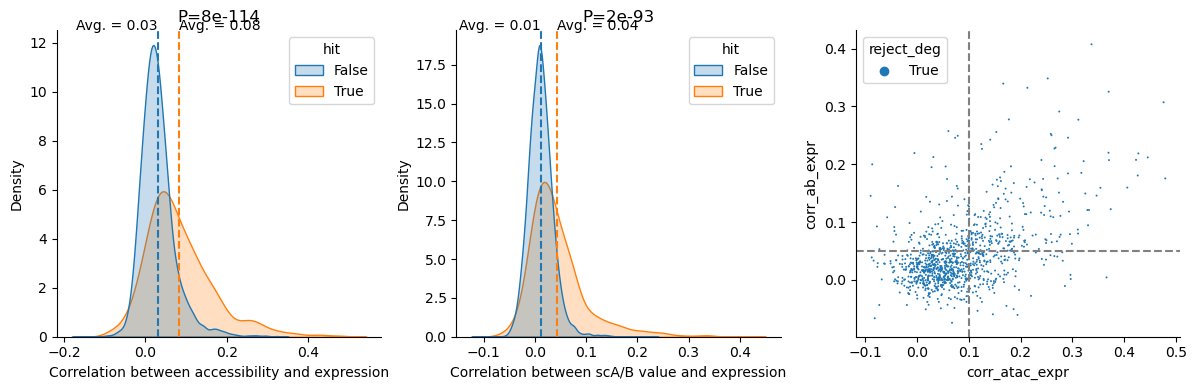

In [16]:
def plot_corr_hit(df, ax=None):
	if ax is None:
		fig, ax = plt.subplots(figsize=(6, 6))
	sns.kdeplot(
		ax=ax, data=df, x='corr', hue='hit', common_norm=False, fill=True,
		hue_order=[False, True])
	mean_false, mean_true = df.groupby('hit')['corr'].mean().values
	stat, pval = mannwhitneyu(df.loc[df['hit'].eq(True), 'corr'], df.loc[df['hit'].eq(False), 'corr'])
	ax.axvline(mean_false, c='C0', linestyle='--')
	ax.axvline(mean_true, c='C1', linestyle='--')
	ax.text(mean_false, ax.get_ylim()[1], f'Avg. = {mean_false:.2f}', horizontalalignment='right')
	ax.text(mean_true, ax.get_ylim()[1], f'Avg. = {mean_true:.2f}')
	ax.set(
		title=f'P={pval:.0e}',
		xlabel='Interaction-expression correlation',
	)
	ax.spines[['right', 'top']].set_visible(False)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes[0]
plot_corr_hit(df_genes.rename(columns={'corr_atac_expr': 'corr', 'reject_deg': 'hit'}), ax=ax)
ax.set(xlabel='Correlation between accessibility and expression')
ax = axes[1]
plot_corr_hit(df_genes.rename(columns={'corr_ab_expr': 'corr', 'reject_deg': 'hit'}), ax=ax)
ax.set(xlabel='Correlation between scA/B value and expression')
ax = axes[2]
sns.scatterplot(
    ax=ax, data=df_genes[df_genes['reject_deg']], x='corr_atac_expr', y='corr_ab_expr',
    s=2, hue='reject_deg', edgecolor='none')
ax.spines[['right', 'top']].set_visible(False)
ax.axvline(.1, linestyle='--', color='grey')
ax.axhline(.05, linestyle='--', color='grey')

fig.tight_layout()
plt.show()
plt.close('all')

In [17]:
mask_ab = df_genes['corr_ab_expr'] > .05
mask_atac = df_genes['corr_atac_expr'] > .1
df = pd.DataFrame([mask_ab, mask_atac]).T[df_genes['reject_deg']]
df.groupby(list(df.columns)).size().unstack()

corr_atac_expr,False,True
corr_ab_expr,,
False,564,142
True,142,218


# 6. Representative loci

In [18]:
def subset_atac_features(adata_atac, chrom, start, end, res, smooth_weight):
	start, end = int(np.floor(start / res)), int(np.ceil(end / res))
	feat_name = np.array([f'{chrom}:{p}-{p+res}' for p in np.arange(start, end) * res])
	mask = np.isin(feat_name, adata_atac.var.index)
	feat_atac_local = np.zeros([len(smooth_weight), len(feat_name)])
	feat_atac_local[:, mask] = np.asarray(smooth_weight @ adata_atac[:, feat_name[mask]].copy().X)
	return start, end, feat_atac_local

gene = 'Erbb4'
display(df_gene_anno.loc[gene])
res = int(1e3)
chrom, start, end = df_gene_anno.loc[gene, ['chrom', 'start', 'end']]
start, end = 66_894_000, 66_901_000
start, end, feat_atac_local = subset_atac_features(adata_pairedseq[idx_pairedseq], chrom, start, end, res, smooth_weight)

chrom                                                      chr1
type                                                       gene
start                                                  68032186
end                                                    69108059
strand                                                        -
annotation    gene_id "ENSMUSG00000062209.15"; gene_type "pr...
gene_type                                        protein_coding
ID                                           ENSMUSG00000062209
gene_id                                      ENSMUSG00000062209
Name: Erbb4, dtype: object

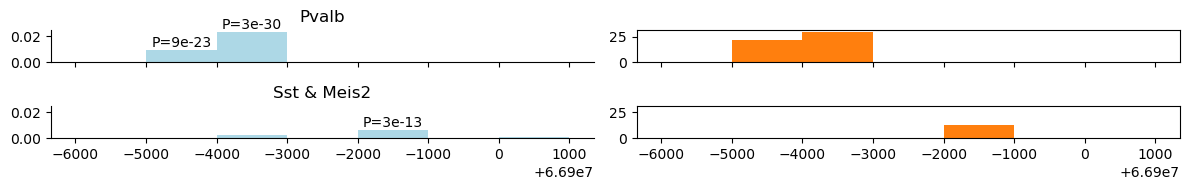

In [19]:
def plot_atac_pseudobulk(start, end, res, setting_list, feat_atac_local, label, pos=None):
	nrow, ncol = len(setting_list), 2
	fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 6, nrow * 1), sharex=True, sharey='col')
	for (ax1, ax2), (title, cell_types) in zip(axes, setting_list.items()):
		x = feat_atac_local[np.isin(label, cell_types)]
		y = feat_atac_local[~np.isin(label, cell_types) & np.isin(label, sum(setting_list.values(), []))]
		p = mannwhitneyu(x, y, alternative='greater', axis=0)[1]
		ax = ax1
		ax.bar(np.arange(start, end) * res, x.mean(0), width=res, align='edge', color='lightblue')
		ax.bar_label(ax.containers[-1], labels=[f'P={_:.0e}' if _ < 1e-2 else '' for _ in p])
		ax.spines[['right', 'top']].set_visible(False)
		ax.set(title=title)
		if pos is not None:
			ax.axvline(pos, linestyle='--', color='grey')
		ax = ax2
		ax.bar(
			np.arange(start, end) * res, -np.log10(p),
			color=np.where(p < 1e-2, 'C1', 'C0'), width=res, align='edge')
	fig.tight_layout()
	plt.show()
	plt.close('all')

setting_list = {
    'Pvalb': ['Pvalb a', 'Pvalb b'],
    'Sst & Meis2': ['Sst a', 'Sst b', 'Meis2'],
}
label = adata_rna.obs.loc[idx_gage, 'cell type'].values
plot_atac_pseudobulk(start, end, res, setting_list, feat_atac_local, label)